In [7]:
import sys; sys.path.append('..')
from typing import List, Tuple, Dict

import torch
import numpy as np
from firelab.config import Config
import matplotlib.pyplot as plt

from src.dataloaders.construct import construct_dataloader

DEVICE = 'cpu'

In [15]:
from firelab.config import Config

dataloader = construct_dataloader(Config({
    'data': {
        'images_dir': {
            'train': '../data/coco/train2014'
        },
        'annotations': {
            'train': '../data/densepose/densepose_coco_2014_train.json'
        }
    },
    'hp': {
        'batch_size': 2
    }
}), is_train=True, is_distributed=False, shuffle=False)

loading annotations into memory...
Done (t=14.14s)
creating index...
index created!


In [16]:
import torch
from typing import List
from torch.utils.data import DataLoader
from torchvision import transforms
from src.dataloaders.coco import CocoDetection
from src.utils.dp_targets import combine_dp_masks

def collate_batch(batch):
    images = [img for img, target in batch]
    targets = [target for img, target in batch]

    return images, targets

def xywh_to_xyxy(bbox) -> List:
    # Converts bbox from coco format (x, y, width, height)
    # to "x1, y1, x2, y2" format (pascal voc?)
    return [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]

def torchvision_target_format(target):
    return {
        'image_id': target[0]['image_id'],
        'labels': torch.Tensor([obj['category_id'] for obj in target]).long().to(DEVICE),
        'boxes': torch.Tensor([xywh_to_xyxy(obj['bbox']) for obj in target]).to(DEVICE),
        'masks': torch.Tensor([obj['mask'] for obj in target]).to(DEVICE),
        'dp_anns': [({
            'dp_I': obj['dp_I'],
            'dp_U': obj['dp_U'],
            'dp_V': obj['dp_V'],
            'dp_x': obj['dp_x'],
            'dp_y': obj['dp_y'],
            'dp_mask': combine_dp_masks(obj['dp_masks']),
        } if 'dp_masks' in obj else None) for obj in target],
    }

train_ds = CocoDetection(f'../data/coco/train2014',
                         f'../data/densepose/densepose_coco_2014_train.json',
                         transform=transforms.ToTensor(),
                         target_transform=torchvision_target_format)

dataloader_old = DataLoader(train_ds, batch_size=2, collate_fn=collate_batch)

loading annotations into memory...
Done (t=13.76s)
creating index...
index created!


In [22]:
data = []
data_old = []

for i, b in enumerate(dataloader):
    if i > 100: break
    data.extend([(img.permute(1,2,0), t) for (img, t) in zip(*b)])
    
for i, b in enumerate(dataloader_old):
    if i > 100: break
    data_old.extend([(img.permute(1,2,0), t) for (img, t) in zip(*b)])

# data_old = [(img.permute(1,2,0), t) for b in dataloader_old for (img, t) in zip(*b)]

def get_first_batches(dataloader, n):
    result = []
    
    for i, b in enumerate(dataloader):
        if i > n: break
        result.extend([(img.permute(1,2,0), t) for (img, t) in zip(*b)])
        
    return result

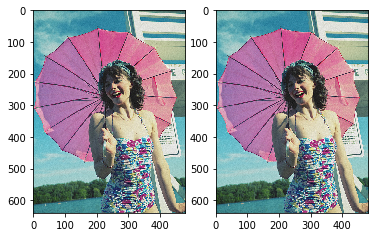

In [23]:
plt.subplot(121)
plt.imshow(data[0][0])

plt.subplot(122)
plt.imshow(data_old[0][0])

In [24]:
from tqdm import tqdm

for img_i in tqdm(range(len(data))):
    #if data[img_i][0].tolist() != data_old[img_i][0].tolist():
    #    print(f'Different imgs: {img_i}')
    
    for obj_i, dp_anns in enumerate(data[img_i][1]['dp_anns']):
        if dp_anns is None: continue

        for key in data[img_i][1]['dp_anns'][obj_i]:
            val = data[img_i][1]['dp_anns'][obj_i][key]
            val_old = data_old[img_i][1]['dp_anns'][obj_i][key]

            if type(val) != list:
                val = val.tolist()
                val_old = val_old.tolist()
            
            if val != val_old:
                print(f'{key}!')

100%|██████████| 202/202 [00:01<00:00, 183.67it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


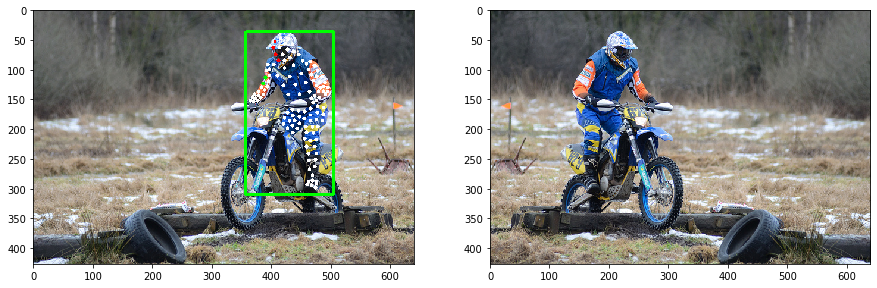

In [21]:
import matplotlib.pyplot as plt
import utils
from src.structures.bbox import Bbox

batch = next(iter(dataloader))
img, target = batch[0][0], batch[1][0]
bbox = Bbox.from_torch_tensor(target['boxes'][0])
dp_I = target['dp_anns'][0]['dp_I']
dp_x = target['dp_anns'][0]['dp_x']
dp_y = target['dp_anns'][0]['dp_y']

img = img.permute(1,2,0).numpy()
img = utils.add_bbox_to_img(img, bbox, lw=3)
img = utils.add_points_to_image(img, dp_I, dp_x, dp_y, bbox)

plt.figure(figsize=(15, 10))

plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(utils.load_img(target['image_id'], 'train'))

In [4]:
tiny_annos = train['annotations'][:100]
tiny_annos_imgs_idx = set([a['image_id'] for a in tiny_annos])
tiny_annos_imgs = [img for img in train['images'] if img['id'] in tiny_annos_imgs_idx]

tiny_coco = {
    'images': tiny_annos_imgs,
    'annotations': tiny_annos,
    'categories': train['categories']
}

with open('../data/densepose/densepose_coco_2014_small.json', 'w') as f:
    json.dump(tiny_coco, f)

In [403]:
from src.structures.bbox import Bbox
from utils import load_img

# ann = train['annotations'][0]
ann = [a for a in tiny_coco['annotations'] if a['id'] == 1249960][0]
img = load_img(ann['image_id'])
bbox = Bbox.from_coco_ann(ann)
proposal = Bbox(380, 70, 140, 250)
red, green, blue = (255, 0, 0), (0, 255, 0), (0, 0, 255)

In [6]:
# cv2.remap(np.arange(16).reshape(4,4), [0, 1], [0.5, 1.5], cv2.INTER_NEAREST)

In [7]:
import matplotlib.pyplot as plt

def get_point_coords(ann, point_i):
    point = [ann['dp_x'][point_i], ann['dp_y'][point_i]]
    point[0] = ann['bbox'][0] + (point[0] / 256) * ann['bbox'][2]
    point[1] = ann['bbox'][1] + (point[1] / 256) * ann['bbox'][3]
    point = [int(p) for p in point]
    
    return point


def add_bbox_to_img(img, bbox:Bbox, color=green, lw=1):
    result = img.copy()
    cv2.rectangle(result, bbox.discretize().corners()[:2], bbox.discretize().corners()[2:], color, lw)
    
    return result


for i in range(len(ann['dp_I'])):
    point = get_point_coords(ann, i)
    label = ann['dp_I'][i]
    if label == 24:
        color = red
    elif label == 1:
        color = blue
    elif label == 17:
        color = green
    else:
        color = (255, 255, 255)
    cv2.rectangle(img, tuple(point), tuple(point), color, 5)
    
# cv2.rectangle(img, bbox.discretize().corners()[:2], bbox.discretize().corners()[2:], green, 3)
# cv2.rectangle(img, proposal.discretize().corners()[:2], proposal.discretize().corners()[2:], blue, 3)
img = add_bbox_to_img(img, bbox)
img = add_bbox_to_img(img, proposal, color=blue)
plt.figure(figsize=(15, 7))
plt.imshow(img)

In [8]:
from pycocotools import mask as mask_utils

masks = np.array([mask_utils.decode(m) if isinstance(m, dict) else np.zeros((256, 256)) for m in ann['dp_masks']])

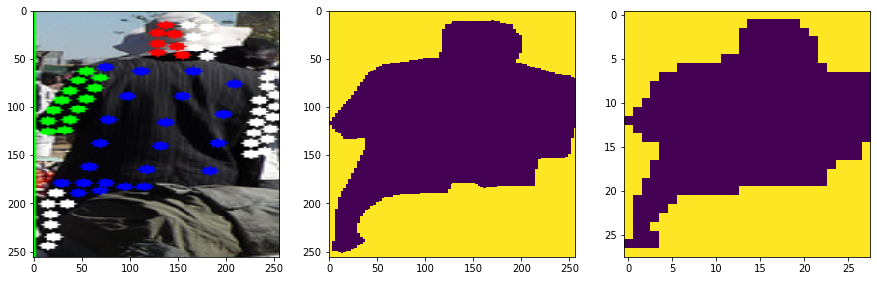

In [9]:
import src.utils.dp_targets
from skimage.transform import resize

bb = bbox.discretize()
bg_mask = np.invert(masks.sum(axis=0).astype(bool))

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(resize(img[bb.y:bb.y + bb.height, bb.x:bb.x + bb.width], (256, 256)))

plt.subplot(132)
plt.imshow(bg_mask)

plt.subplot(133)
# plt.imshow(resize(bg_mask.astype(np.float), (28, 28)) > 0.5)
plt.imshow(src.utils.dp_targets.downsample_mask(bg_mask, 28))

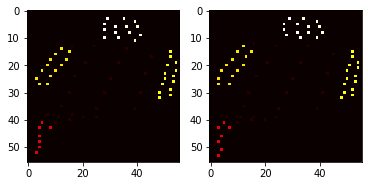

In [10]:
ann = tiny_coco['annotations'][3]
gt_bbox = Bbox.from_coco_ann(ann)
proposal = Bbox.from_coco_ann(ann).discretize()
result = src.utils.dp_targets.create_target_for_dp(ann, gt_bbox, proposal, 56)

plt.subplot(121)
mask = np.zeros((56, 56))
mask[result['dp_y'], result['dp_x']] = result['dp_I']
plt.imshow(mask, cmap='hot')

plt.subplot(122)
mask = np.zeros((56, 56))
mask[(np.array(ann['dp_y']) / 256 * 56).astype(int), (np.array(ann['dp_x']) / 256 * 56).astype(int)] = ann['dp_I']
plt.imshow(mask, cmap='hot')

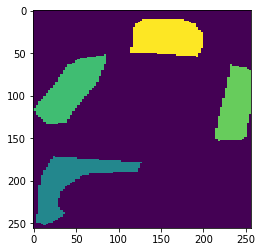

In [11]:
bp_masks = [mask_utils.decode(m) if isinstance(m, dict) else np.zeros((256, 256)) for m in ann['dp_masks']]
bp_masks = np.array(bp_masks)
bp_mask = bp_masks.astype(bool).argmax(axis=0)
plt.imshow(bp_mask)

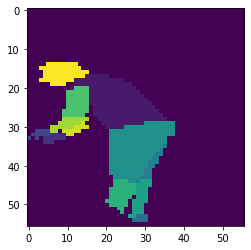

In [155]:
from importlib import reload
import src.utils.dp_targets
reload(src.utils.dp_targets)
reload(src.structures.bbox)

M = 56

ann = train['annotations'][0]
gt_bbox = Bbox.from_coco_ann(ann)
proposal = Bbox(gt_bbox.x1, gt_bbox.y1 - 100, gt_bbox.x2 + 50, gt_bbox.y2, format='xyxy')
dp_targets = src.utils.dp_targets.create_target_for_dp(ann, gt_bbox, proposal, M)
cls_logits = torch.randn(25, M, M)

# plt.figure(figsize=(15, 15))
plt.imshow(dp_targets['dp_mask'])

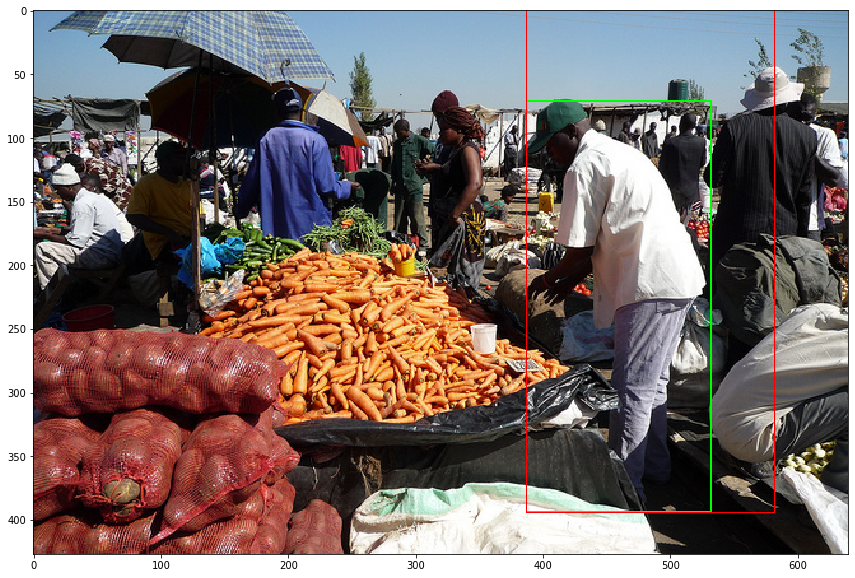

In [156]:
plt.figure(figsize=(15, 10))
img = load_img(train['annotations'][0]['image_id'])
img = add_bbox_to_img(img, gt_bbox, green)
img = add_bbox_to_img(img, proposal, red)
plt.imshow(img)

In [422]:
import json
from tqdm import tqdm

path = '../experiments/experiment-00060/custom_data/val_results/iter-56.json'
data = json.load(open(path))
data = data[:100]

def _decodeUvData(dt):
    from PIL import Image
    import io
    from base64 import b64decode
    uvData = dt['uv_data']
    uvShape = dt['uv_shape']
    fStream = io.BytesIO(b64decode(uvData))
    im = Image.open(fStream)
    data = np.rollaxis(np.array(im.getdata(), dtype=np.uint8), -1, 0)
    dt['uv'] = data.reshape(uvShape)

# data = [_decodeUvData(d) for d in data]
for dt in tqdm(data):
    _decodeUvData(dt)


100%|██████████| 100/100 [00:06<00:00, 13.88it/s]

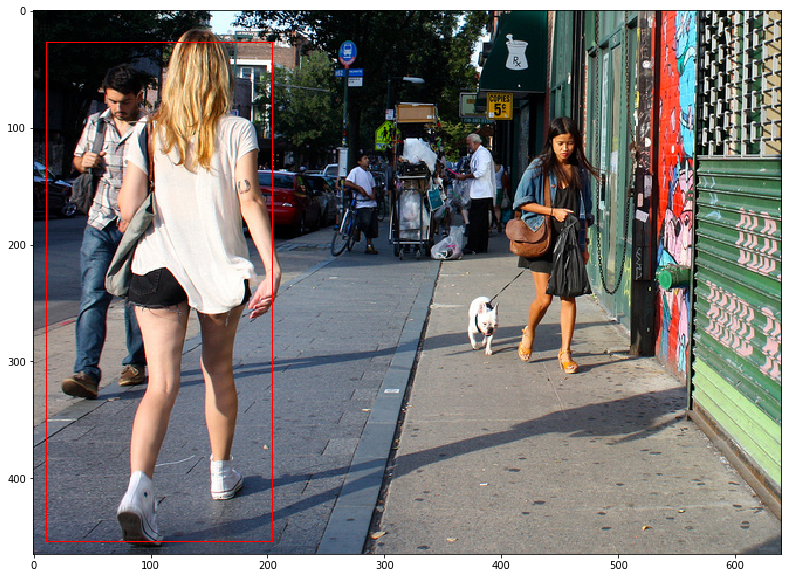

In [424]:
img_id = data[0]['image_id']
img = load_img(img_id, 'train')

for i, pred in enumerate(data):
    if pred['image_id'] != img_id: continue
    #if pred['score'] < 0.99: continue
    if i != 0: continue
    pred_bbox = Bbox(*pred['bbox'])
    img = add_bbox_to_img(img, pred_bbox, color=red)
    #img = add_bbox_to_img(img, Bbox.from_coco_ann(train['annotations'][3]), color=green)

plt.figure(figsize=(15, 10))
plt.imshow(img)

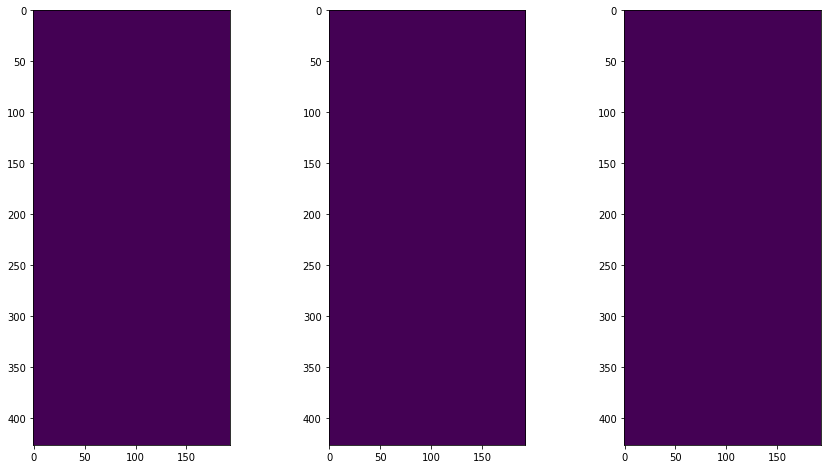

In [425]:
plt.figure(figsize=(15, 8))
plt.subplot(131)
plt.imshow(data[0]['uv'][0])
plt.subplot(132)
plt.imshow(data[0]['uv'][1])
plt.subplot(133)
plt.imshow(data[0]['uv'][2])

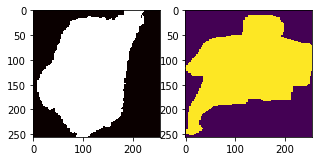

In [98]:
plt.figure(figsize=(5, 10))

plt.subplot(121)
plt.imshow(resize((data[0]['uv'][0] != 0).astype(float), (256, 256)) > 0.5, cmap='hot')

plt.subplot(122)
plt.imshow(np.array([mask_utils.decode(m) for m in train['annotations'][3]['dp_masks'] if isinstance(m, Dict)]).astype(bool).sum(axis=0))